In [2]:
import numpy as np
import serial
import time
import h5py
from datetime import datetime
from datetime import date
import cv2
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
def tactile_reading(path):
    """
    Reads tactile sensor data from an HDF5 file.

    This function opens an HDF5 file at the specified path and extracts 
    tactile sensor data, including frame count, timestamps, pressure readings, 
    and packet IDs. The data is then returned as numpy arrays.

    Parameters:
    path (str): The path to the HDF5 file containing the tactile sensor data.

    Returns:
    tuple:
        pressure (np.ndarray): An array of pressure readings with shape (frame_count,rows,cols). (32x32 by default)
        frame_count (int): The number of frames (or data points) in the file.
        ts (np.ndarray): An array of timestamps with shape (frame_count,).
        packetIDs (np.ndarray): An array of packet IDs with shape (frame_count,9). Represents all packetIDs received during a frame. 
    """
    f = h5py.File(path, 'r')
    fc = f['frame_count'][0]
    ts = np.array(f['ts'][:fc])
    pressure = np.array(f['pressure'][:fc]).astype(np.float32)
    packetIDs = np.array(f['packetNumber'][:fc])
    preds = np.array(f['predCount'][:fc])
    return pressure, fc, ts, packetIDs,preds

def tactile_reading_new(path):
    """
    Reads tactile sensor data from an HDF5 file.

    This function opens an HDF5 file at the specified path and extracts 
    tactile sensor data, including frame count, timestamps, pressure readings, 
    and packet IDs. The data is then returned as numpy arrays.

    Parameters:
    path (str): The path to the HDF5 file containing the tactile sensor data.

    Returns:
    tuple:
        pressure (np.ndarray): An array of pressure readings with shape (frame_count,rows,cols). (32x32 by default)
        frame_count (int): The number of frames (or data points) in the file.
        ts (np.ndarray): An array of timestamps with shape (frame_count,).
        packetIDs (np.ndarray): An array of packet IDs with shape (frame_count,9). Represents all packetIDs received during a frame. 
    """
    f = h5py.File(path, 'r')
    fc = f['frame_count'][0]
    ts = np.array(f['ts'][:fc])
    pressure = np.array(f['pressure'][:fc]).astype(np.float32)
    packetIDs = np.array(f['packetNumber'][:fc])
    preds = np.array(f['predCount'][:fc])
    receivedPacketCount = np.array(f['receivedPacketCount'][:fc])
    return pressure, fc, ts, packetIDs,preds, receivedPacketCount

In [4]:
def split_into_segments(arr, timeStamps, N):
    """
    Splits the data into N segments based on timestamps.

    This function divides the pressure, frame count, timestamps, and packet loss data
    into N approximately equal segments based on the total duration of the timestamps. 
    Each segment contains the data within its respective time range.

    Parameters:
    pressure (np.ndarray): An array of pressure readings.
    frame_count (np.ndarray): An array of frame counts.
    time_stamp (np.ndarray): An array of timestamps.
    packet_loss (np.ndarray): An array of packet loss information.
    N (int): The number of segments to split the data into.

    Returns:
    tuple:
        pressure_segments (list of np.ndarray): A list of pressure reading segments.
        frame_count_segments (list of np.ndarray): A list of frame count segments.
        time_stamp_segments (list of np.ndarray): A list of timestamp segments.
        packet_loss_segments (list of np.ndarray): A list of packet loss segments.
    """
    # Calculate the total duration
    total_duration = timeStamps[-1] - timeStamps[0]
    
    # Calculate the approximate duration for each segment
    segment_duration = total_duration / N
    
    # Initialize lists to hold the segments
    arrSegments = []

    # Initialize the start index for the first segment
    start_index = 0

    for i in range(N):
        # Determine the end time for the current segment
        end_time = timeStamps[0] + (i + 1) * segment_duration
        
        # Find the index where the time_stamp exceeds the end_time
        end_index = np.searchsorted(timeStamps, end_time, side='right')
        
        # Slice the arrays to form the current segment
        arrSegments.append(arr[start_index:end_index])
        
        # Update the start index for the next segment
        start_index = end_index

    return arrSegments

In [13]:
expPressure, expFC, expTS, expPacketIDs,expPreds = tactile_reading(".hdf5")
print(expPreds[-1])
print(max(expPacketIDs[-1]))
print((max(expPacketIDs[-1])-expPreds[-1])/max(expPacketIDs[-1]))

7925.0
8089
0.020274446779577203


In [43]:
expPressure, expFC, expTS, expPacketIDs,expPreds = tactile_reading("wifiData.hdf5")
# actualPressure, actualFc, actualTS, actualPacketIDs, actualPreds = tactile_reading("serialData.hdf5")
# print(expFC, actualFc)
# closest_index = np.abs(expTS - actualTS[0]).argmin()
# expArrays = [expPressure, expTS,expPacketIDs,expPreds]
# actualArrays = [actualPressure, actualTS, actualPacketIDs]
# for arr in expArrays:
#     arr = arr[closest_index:]
# trimLen = min(len(expArrays[0]), len(actualArrays[0]))
# expArrays = [arr[:trimLen] for arr in expArrays]
# actualArrays = [arr[:trimLen] for arr in actualArrays]

# for d = 16, 21, 26, 31, 36, 41:
ds = [16, 21, 26, 31, 36, 41]
startTimes = [1720567109.292828,1720566354.332535, 1720565612.767341, 1720564854.123046, 1720564055.997741, 1720563216.366472]

#{d: {predPressure,predTS, predPacketIDs,predPredCount, truePressure, trueTS, truePacketIDs}}
dataDict = {}
# load pred and true
def getStartIdx(arr, Ts):
    return np.abs(arr - Ts).argmin()

minDuration = None
for i in range(len(ds)):
    d=ds[i]
    startTs = startTimes[i]
    thisData = {}
    predPressure, _, predTS, predPacketIDs, predPredCount = tactile_reading(f"d{d}pred.hdf5")
    endTs = predTS[-1]
    if minDuration is None:
        minDuration = endTs-startTs
    elif endTs - startTs < minDuration:
        minDuration = endTs-startTs
    startIdxPred = getStartIdx(predTS, startTs)
    thisData["predPressure"] = predPressure[startIdxPred:]
    thisData["predTs"] = predTS[startIdxPred:]
    thisData["predPacketIDs"] = predPacketIDs[startIdxPred:]
    thisData["predPredCount"] = predPredCount[startIdxPred:]
    truePressure,_,trueTs, truePacketIDs,_ = tactile_reading(f"d{d}true.hdf5")
    startIdxTrue = getStartIdx(trueTs,startTs)
    thisData["truePressure"]=truePressure[startIdxTrue:]
    thisData["trueTS"]=trueTs[startIdxTrue:]
    thisData["truePacketIds"]=truePacketIDs[startIdxTrue:]
    dataDict[d] = thisData

# start slice from closest TS according to recorded TS 
# end slice according to shortest duration from all d's
# divide all arrays into 5 experiments of equal TS length

for d in list(dataDict.keys()):
    predTs =dataDict[d]["predTs"]
    trueTs = dataDict[d]["trueTS"]
    predEndIdx = getStartIdx(predTS, predTS[0]+minDuration)
    trueEndIdx = getStartIdx(trueTs, trueTs[0]+minDuration)
    for arrName in list(dataDict[d].keys()):
        if "pred" in arrName:
            dataDict[d][arrName] = split_into_segments(dataDict[d][arrName][:predEndIdx],predTS[:predEndIdx],5)
        else:
            dataDict[d][arrName] = split_into_segments(dataDict[d][arrName][:trueEndIdx],trueTs[:trueEndIdx],5)





#[(avg, std)]
actualPercent = []
actualNrmse = []
actualObj = []

#[vals]
simPercent = [0.20641422719552402, 0.016684983514836646, 0.007593166150464582, 0.005295234289139774, 0.0036966729943051255,0.0027974822659606355]
simNRMSE = [0.01532273265233178, 0.01743904347184517, 0.019153949079147217, 0.020387577151867994, 0.022699335871683882, 0.02362517166768427]
simObj = [0.06309560628812984, 0.017250528482593036, 0.016263753346976557, 0.01661449143618594, 0.017948670152339193, 0.01841824931725336]

#{d: (percent[5], nrmse[5])}
resultsDict = {}

# for i in range(numExp)
# calculate percent sent for all d
# calculate RMSE for all d

def calcNRMSE(truePressure, predPressure):
    if len(truePressure)!= len(predPressure):
        minLen = min(len(truePressure), len(predPressure))
        truePressure=truePressure[:minLen]
        predPressure=predPressure[:minLen]
    error = truePressure-predPressure
    # Compute the RMSE
    mse = np.mean(error ** 2)
    rmse_value = np.sqrt(mse)
    range_y = np.max(truePressure) - np.min(truePressure)
    nrmse = rmse_value/range_y
    return nrmse

#Percent of packets sent
def calcPercent(truePacketIds, predCount):
    thisPredCount = predCount[-1]-predCount[0]
    startPacketIds = truePacketIds[0][truePacketIds[0]!=0]
    endPacketIDs = truePacketIds[-1][truePacketIds[-1]!=0]
    totalProcessed = max(endPacketIDs)-min(startPacketIds)
    return (totalProcessed-thisPredCount)/totalProcessed
    



#calculate mean and std  NRMSE and % for all d

for d in list(dataDict.keys()):
    alpha=0.75
    percents = []
    nrmses = []
    for i in range(5):
        percents.append(calcPercent(dataDict[d]["truePacketIds"][i], dataDict[d]["predPredCount"][i]))
        nrmses.append(calcNRMSE(dataDict[d]["truePressure"][i], dataDict[d]["predPressure"][i]))
    print(f"Experiment {d}, Percents: {percents}, NRMSES: {nrmses}")
    
    actualPercent.append((np.mean(percents), np.std(percents)))
    actualNrmse.append((np.mean(nrmses), np.std(nrmses)))
    actualObj.append((alpha * np.mean(nrmses) + (1 - alpha) * np.mean(percents), alpha * np.std(nrmses) + (1 - alpha) * np.std(percents)))

print(f"Percentages: {actualPercent}")
print(f"Nrmses: {actualNrmse}")
print(f"Objective Function: {actualObj}")



#get simulated NRSME and % for all d


Experiment 16, Percents: [np.float64(0.1895004233700254), np.float64(0.19134860050890584), np.float64(0.18157181571815717), np.float64(0.18580623306233063), np.float64(0.15901778154106688)], NRMSES: [np.float32(0.008010103), np.float32(0.007896457), np.float32(0.008140525), np.float32(0.008258065), np.float32(0.009839503)]
Experiment 21, Percents: [np.float64(0.06037099494097808), np.float64(0.06046275966897484), np.float64(0.059359190556492414), np.float64(0.07363621009964533), np.float64(0.03169785870848087)], NRMSES: [np.float32(0.00960744), np.float32(0.010120367), np.float32(0.010275402), np.float32(0.010562947), np.float32(0.013603901)]
Experiment 26, Percents: [np.float64(0.04176490400808353), np.float64(0.040809443507588535), np.float64(0.03946037099494098), np.float64(0.055658627087198514), np.float64(0.014814814814814815)], NRMSES: [np.float32(0.010079532), np.float32(0.010821667), np.float32(0.01129618), np.float32(0.011757183), np.float32(0.015165832)]
Experiment 31, Percen

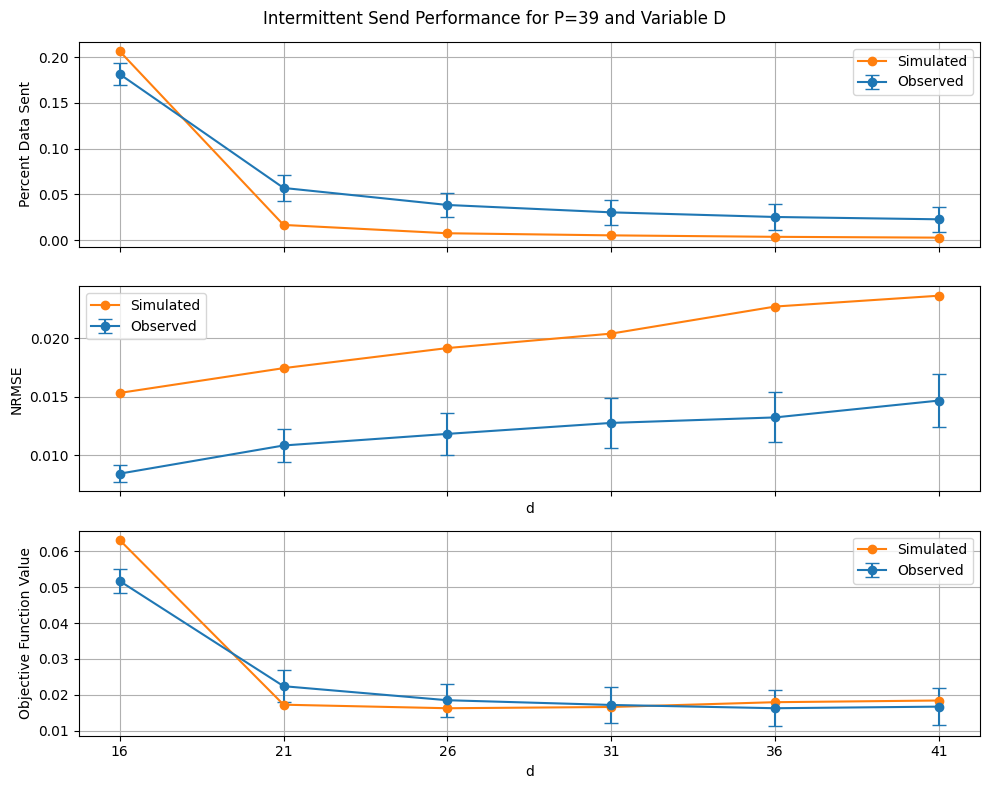

In [51]:


# Unpack mean and std
percent_means, percent_stds = zip(*actualPercent)
nrmse_means, nrmse_stds = zip(*actualNrmse)
obj_means, obj_stds = zip(*actualObj)

# Create the figure and axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
fig.suptitle("Intermittent Send Performance for P=39 and Variable D")

# Plot percent data
ax1.errorbar(ds, percent_means, yerr=percent_stds, fmt='o', capsize=5, label='Observed', linestyle="-")
ax1.plot(ds, simPercent,label='Simulated', linestyle="-", marker="o")
ax1.set_ylabel('Percent Data Sent')
ax1.legend()
ax1.grid(True)

# Plot nrmse data
ax2.errorbar(ds, nrmse_means, yerr=nrmse_stds, fmt='o', capsize=5, label='Observed', linestyle="-")
ax2.plot(ds, simNRMSE,label='Simulated', linestyle="-", marker="o")
ax2.set_xlabel('d')
ax2.set_ylabel('NRMSE')
ax2.legend()
ax2.grid(True)

# Plot obj function data
ax3.errorbar(ds, obj_means, yerr=obj_stds, fmt='o', capsize=5, label='Observed', linestyle="-")
ax3.plot(ds, simObj,label='Simulated', linestyle="-", marker="o")
ax3.set_xlabel('d')
ax3.set_ylabel('Objective Function Value')
ax3.legend()
ax3.grid(True)
# Show plot
plt.xticks(ds)
plt.tight_layout()
plt.show()


In [18]:


expPressureSegments, expTimeStampSegments,expPredSegments = split_into_segments(expArrays[0],expArrays[1],expArrays[2])
actualPressureSegments, actualTimeStampSegments, 

1720455521.578275 1720455521.585319
0
1720455521.585319 1720455657.379723 1720455521.578275 1720455656.731715


In [20]:
print(expPressure.shape, actualPressure[:791].shape)
actualPressure = actualPressure[:791]




(791, 32, 32) (791, 32, 32)
18.033298
0.016379017


In [ ]:
#Read Only, Read + Send, Est Send Only, 
wifiPwrs = [147]

In [5]:
ble_data = pd.read_csv("intermittentShoe.csv")

In [20]:
print(len(ble_data['Timestamp(ms)']))

300001


In [6]:
current = ble_data['Current(uA)']
energy = [0]
for i in range(1,len(current)):
    energy.append(energy[i-1]+current[i]*3.3*0.01*1e-3)

In [50]:
averageCurrent = []
winsize = int(1/(1e-3))
i = 0
for i in range(len(current)):
    lowerBound = max(i-winsize,0)
    upperBound = min(i+winsize,len(current))
    averageCurrent.append(sum(current[lowerBound:upperBound])/(upperBound-lowerBound))

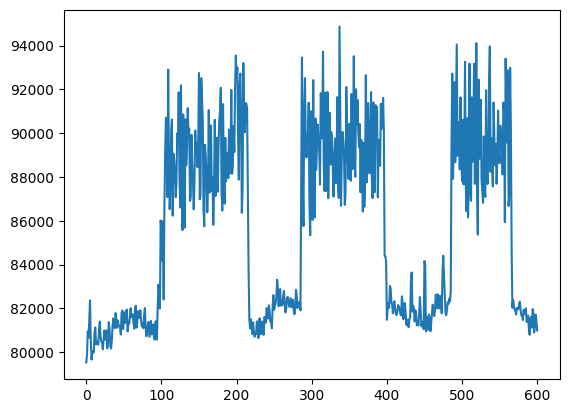

In [16]:
plt.plot(averageCurrent)

510 1723744458.001229


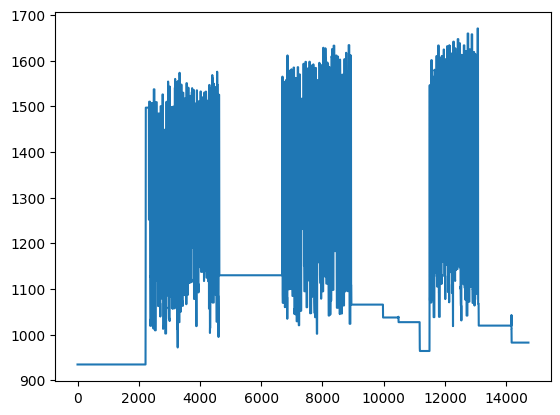

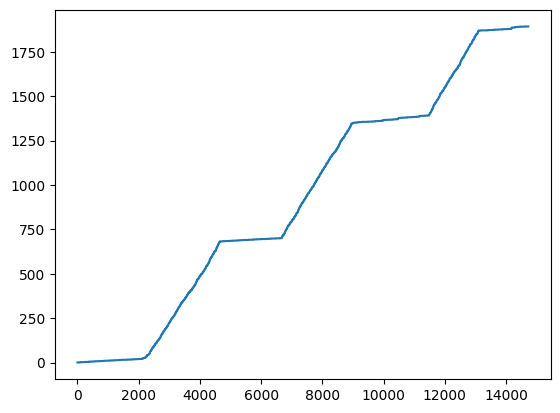

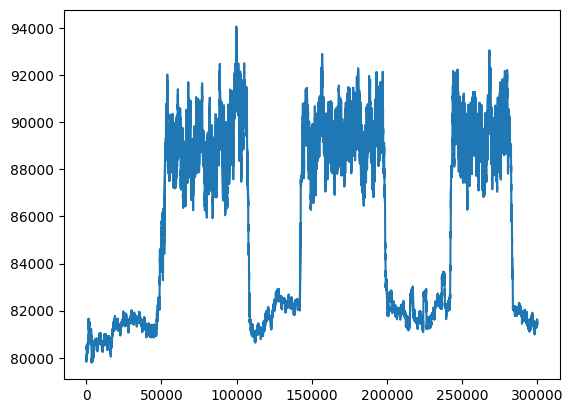

In [52]:
def find_closest_index(array, value):
    index = (np.abs(array - value)).argmin()
    return index, array[index]

# Get total length of current collection
# Trim the hdf5 data to the start and end of the current collection
# Hdf5 data needed: Pressure, Timestamp. PredCount. PacketNumber
# Received packets = max(packetNumber)-predCount?
# Get average of current over some window size
# Align x scales
shoePressure, shoeFc,shoeTs, shoePacketIds,shoePreds = tactile_reading("intermittentShoe.hdf5")

#take about 5 minutes from the end of the recording
LasTs = shoeTs[-1]

endIdx, endVal = find_closest_index(shoeTs, LasTs-5)
startTs = endVal-5*60
startIdx, startTs = find_closest_index(shoeTs, startTs)
print(startIdx, startTs)
avgReadings = [np.mean(shoePressure[i,:,:])for i in range(startIdx, endIdx)]
currPacketId = np.max(shoePacketIds[startIdx])
numReceived = 1
packetsReceived = [1]
for i in range(startIdx+1, endIdx):
    maxVal = np.max(shoePacketIds[i])
    if maxVal > currPacketId:
        numReceived+=1
        currPacketId=maxVal
    packetsReceived.append(numReceived)
plt.plot(avgReadings)
plt.figure()
plt.plot(packetsReceived)
plt.figure()
plt.plot(averageCurrent)
avgReadingTs = np.linspace(0,300,len(avgReadings))
packetsReceivedTs = np.linspace(0,300,len(packetsReceived))
averageCurrentTs = np.linspace(0,300,len(averageCurrent))
    

In [53]:
import csv

# Function to save data to a CSV file
def save_to_csv(filename, timestamps, data, heading):
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Timestamp", heading])
        for i in range(len(data)):
            writer.writerow([timestamps[i], data[i]])
    print(f"Data saved to {filename}")

# Save avgReadings to a CSV file
save_to_csv("shoeAvgReadings.csv", avgReadingTs, avgReadings, "avgReadings")

# Save packetsReceived to a CSV file
save_to_csv("shoePacketsReceived.csv", packetsReceivedTs, packetsReceived, "packetsReceived")

# Save averageCurrent to a CSV file
save_to_csv("shoeAverageCurrent.csv", averageCurrentTs, averageCurrent, "averageCurrent")

Data saved to shoeAvgReadings.csv
Data saved to shoePacketsReceived.csv
Data saved to shoeAverageCurrent.csv


In [15]:
thisPressure, thisFc, thisTS, thisPacketIds, thisPred, thisPacketCount = tactile_reading_new("intermittentShoe.hdf5")

packetsReceived = [max(thisPacketIds[n])-thisPred[n] for n in range(len(thisPacketIds))]

plt.plot(thisPacketCount)


KeyError: "Unable to synchronously open object (object 'receivedPacketCount' doesn't exist)"

In [19]:

def linear_interpolate_below_threshold(arr, threshold):
    # Find the indices where values are above the threshold
    above_threshold_indices = np.where(arr > threshold)[0]
    
    # If there are fewer than 2 points above the threshold, interpolation is not possible
    if len(above_threshold_indices) < 2:
        raise ValueError("Need at least two points above the threshold for interpolation")
    
    # Copy the original array to avoid modifying it directly
    interpolated_arr = np.copy(arr)
    
    # Loop through the ranges defined by consecutive points above the threshold
    for i in range(len(above_threshold_indices) - 1):
        start_idx = above_threshold_indices[i]
        end_idx = above_threshold_indices[i + 1]
        
        # Get the start and end values
        start_val = arr[start_idx]
        end_val = arr[end_idx]
        
        # Linearly interpolate values between start_idx and end_idx
        for j in range(start_idx + 1, end_idx):
            interpolated_arr[j] = start_val + (end_val - start_val) * (j - start_idx) / (end_idx - start_idx)
    
    return interpolated_arr

# Example usage
arr = np.array([5, 6, 0, 0, 0, 0, 11, 12])
threshold = 2
interpolated_arr = linear_interpolate_below_threshold(arr, threshold)
print("Original array:", arr)
print("Interpolated array:", interpolated_arr)

Original array: [ 5  6  0  0  0  0 11 12]
Interpolated array: [ 5  6  7  8  9 10 11 12]


In [49]:
fixedFile = h5py.File("./blep15d41new.hdf5", 'w')
oldFile = h5py.File("./blep15d41.hdf5", 'r')



# Function to copy data
def copy_data(src, dst, fix_dataset_name, fix_function):
    for name, item in src.items():
        if isinstance(item, h5py.Group):
            # Create a group in the destination file
            dst_group = dst.create_group(name)
            # Recursively copy the group's items
            copy_data(item, dst_group, fix_dataset_name, fix_function)
        elif isinstance(item, h5py.Dataset):
            if name == fix_dataset_name:
                # Apply the fix to the dataset
                fixed_data = fix_function(item[:])
                dst.create_dataset(name, data=fixed_data)
                receivedPackets = calculate_received_packets(item[:],item[:][0])
                dst.create_dataset('receivedPacketCount', data=receivedPackets)
                currentData = createCurrentData(fixed_data)

            elif name == "pressure" or name =="fc":
                # Copy the dataset as is
                dst.create_dataset(name, data=item[:])
    
    

# Define a function to fix the specific dataset
def fix_specific_dataset(data):
    # Apply the necessary fix to the dataset
    # For example, let's assume we want to multiply the dataset by 2
    threshold = data[0]//1000
    
    return linear_interpolate_below_threshold(data,threshold)

# Copy data from oldFile to fixedFile with the specific dataset fixed
copy_data(oldFile, fixedFile, 'ts', fix_specific_dataset)

# Close the files
oldFile.close()
fixedFile.close()


In [48]:
def calculate_received_packets(arr,threshold):
    # Find the indices where values are above the threshold
    above_threshold_indices = np.where(arr > threshold)[0]
    packetCount = 0
    packetArr = []
    for i in range(len(arr)):
        if i in above_threshold_indices:
            packetCount+=1
        packetArr.append(packetCount)
    return np.array(packetArr)



2
[0.         0.09173775 0.18347573 0.27521348 0.36695147 0.45868921
 0.5504272  0.64216495 0.73390293 0.82564068 0.91737866 1.00911641
 1.1008544  1.19259238 1.28433013 1.37606812 1.46780586 1.55954385
 1.6512816  1.74301958 1.83475733 1.92649531 2.01823306 2.10997105
 2.20170903 2.29344678 2.38518476 2.47692251 2.5686605  2.66039824]


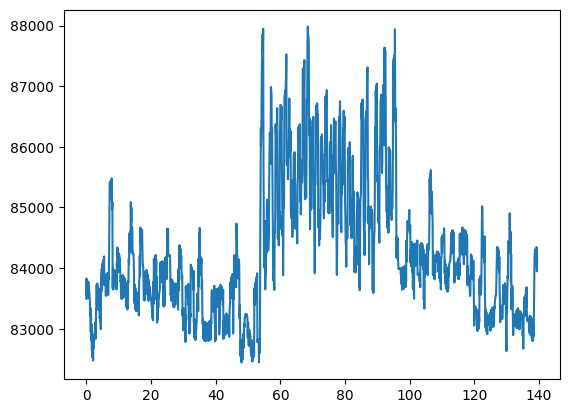

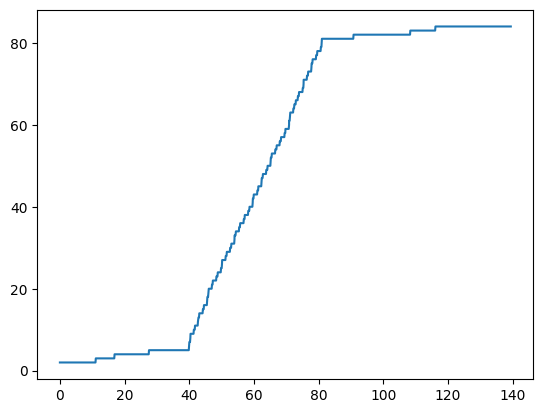

In [99]:
thisPressure, thisFc, thisTS, thisPacketIds, thisPred = tactile_reading("blep21d61.hdf5")
# fixedFile = h5py.File("./blep15d41new.hdf5", 'w')
fixedTs = fix_specific_dataset(thisTS)
packetsReceived = calculate_received_packets(thisTS, thisTS[0]//2)
powerStart = 1721926366.58533
startIdx = np.argmin(np.abs(fixedTs-powerStart)) +1
print(startIdx)
fixedTs=fixedTs[startIdx:]
packetsReceived=packetsReceived[startIdx:]
thisFc-=startIdx
thisPressure=thisPressure[startIdx:]
timeStampDiff = fixedTs-fixedTs[0]
print(timeStampDiff[0:30])


def createCurrentData(timeStamps):
    ble_data = pd.read_csv("blep21d61power.csv")
    current = ble_data['Current(uA)']
    currentTs = ble_data['Timestamp(ms)']*1e-3
    averageCurrent = []
    winsize = int(0.5/(0.01*1e-3))
    for i in range(len(timeStamps)):
        timeStamp = timeStamps[i]
        closestCurrentIdx = np.argmin(np.abs(currentTs-timeStamp))
        minBound = max(closestCurrentIdx-winsize,0)
        maxBound = min(closestCurrentIdx+winsize,len(currentTs))
        averageCurrent.append(np.mean(current[minBound:maxBound]))
    return np.array(averageCurrent)
thisCurrent = createCurrentData(timeStampDiff)
plt.figure()
plt.plot(fixedTs[:1500]-fixedTs[0], thisCurrent[:1500])
plt.figure()
plt.plot(fixedTs[:1500]-fixedTs[0], packetsReceived[:1500])
    


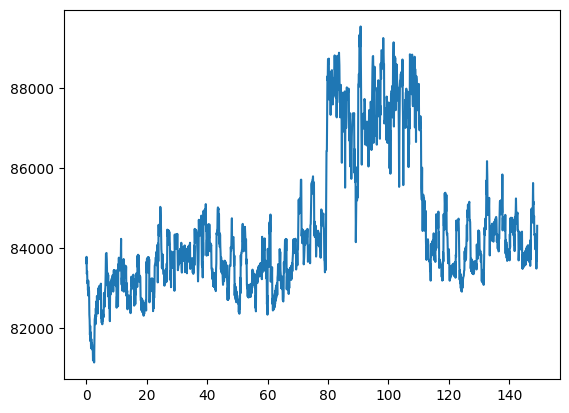

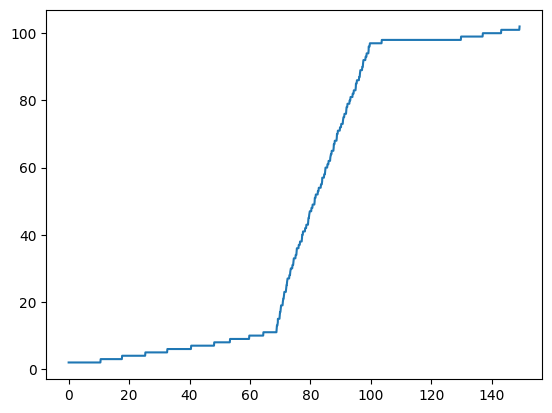

In [75]:
plt.plot(fixedTs[:1587]-fixedTs[0], packetsReceived[:1587])

In [76]:
print(startIdx)

1


In [78]:
newFile = h5py.File("./blep15d41updated.hdf5", 'w')
newFile.create_dataset('ts', data=fixedTs)
newFile.create_dataset('pressure',data=thisPressure)
newFile.create_dataset('fc',data=thisFc)
newFile.create_dataset('current',data=thisCurrent)
newFile.create_dataset('receivedPackets',data=packetsReceived)
newFile.close()



<HDF5 dataset "receivedPackets": shape (1612,), type "<i8">

1612


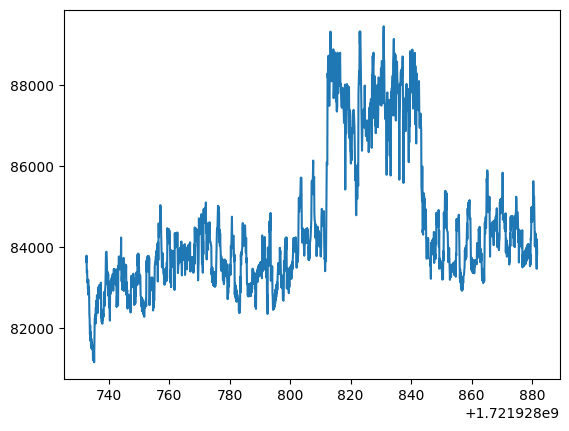

In [98]:
def tactile_reading_updated(path):
    """
    Reads tactile sensor data from an HDF5 file.

    This function opens an HDF5 file at the specified path and extracts 
    tactile sensor data, including frame count, timestamps, pressure readings, 
    and packet IDs. The data is then returned as numpy arrays.

    Parameters:
    path (str): The path to the HDF5 file containing the tactile sensor data.

    Returns:
    tuple:
        pressure (np.ndarray): An array of pressure readings with shape (frame_count,rows,cols). (32x32 by default)
        frame_count (int): The number of frames (or data points) in the file.
        ts (np.ndarray): An array of timestamps with shape (frame_count,).
        packetIDs (np.ndarray): An array of packet IDs with shape (frame_count,9). Represents all packetIDs received during a frame. 
    """
    f = h5py.File(path, 'r')
    fc = f['fc'][()]
    ts = np.array(f['ts'][:fc])
    pressure = np.array(f['pressure'][:fc]).astype(np.float32)
    current = np.array(f['current'][:fc])
    receivedPackets = np.array(f['receivedPackets'][:fc])
    return pressure, fc, ts, current, receivedPackets
p, fc, ts, current, received = tactile_reading_updated('./blep15d41updated.hdf5')
plt.plot(ts[:1586], current[:1586])


In [18]:
def linear_interpolate_below_threshold(arr, threshold):
    # Find the indices where values are above the threshold
    above_threshold_indices = np.where(arr > threshold)[0]
    
    # If there are fewer than 2 points above the threshold, interpolation is not possible
    if len(above_threshold_indices) < 2:
        raise ValueError("Need at least two points above the threshold for interpolation")
    
    # Copy the original array to avoid modifying it directly
    interpolated_arr = np.copy(arr)
    
    # Loop through the ranges defined by consecutive points above the threshold
    for i in range(len(above_threshold_indices) - 1):
        start_idx = above_threshold_indices[i]
        end_idx = above_threshold_indices[i + 1]
        
        # Get the start and end values
        start_val = arr[start_idx]
        end_val = arr[end_idx]
        
        # Linearly interpolate values between start_idx and end_idx
        for j in range(start_idx + 1, end_idx):
            interpolated_arr[j] = start_val + (end_val - start_val) * (j - start_idx) / (end_idx - start_idx)
    
    return interpolated_arr

# Example usage
arr = np.array([5, 6, 0, 0, 0, 0, 11, 12])
threshold = 2
interpolated_arr = linear_interpolate_below_threshold(arr, threshold)
print("Original array:", arr)
print("Interpolated array:", interpolated_arr)

Original array: [ 5  6  0  0  0  0 11 12]
Interpolated array: [ 5  6  7  8  9 10 11 12]
